In [1]:
from pylab import *
import pydot

# An FST Data Structure

There is a close correspondence between regular languages, regular expressions, and finite state machines.

A finite state machine is a directed graph.

Alternatively, it is a collection of states (nodes) and transitions (edges), where each
edge consists of a start state, an end state, and a label.

Finally, we can also view an FST as a sparse matrix, where the columns represent
the old state, the rows represent the new state, and the entries may represent labels
or costs.

Wildcard handling (".") can work differently; here we use a choice that is different
from normal regular expressions: "." only matches if nothing else matches.

In [103]:
class Graph:
    def __init__(self):
        self.states = []
        self.acceptors = set()
    def state(self):
        self.states.append([])
        return len(self.states)-1
    def accept(self,i):
        self.acceptors.add(i)
    def accepted(self,i):
        return i in self.acceptors
    def add(self,i,j,c):
        self.states[i].append((c,j))
    def expand(self,i,q):
        result = []
        for c,j in self.states[i]:
            if c==q: result.append(j)
        if result==[]:
            for c,j in self.states[i]:
                if c==".": result.append(j)
        return result
    

Here is a useful little function for plotting these graphs.

In [104]:
def show(g,rankdir="LR"):
    graph = pydot.Dot(rankdir=rankdir)
    for i,s in enumerate(g.states):
        if g.accepted(i): 
            graph.add_node(pydot.Node(str(i),color="red",penwidth="3"))
        for c,j in s:
            graph.add_edge(pydot.Edge(str(i),str(j),label=str(c)))
    graph.write_png("/tmp/_test.png")
    gca().set_xticks([]); gca().set_yticks([])
    imshow(imread("/tmp/_test.png"))

# Translating a RE to an FST

Let's start with a very simple graph.

This graph corresponds to the regular expression `^ab*c$`.

Note the accept state (in red). The start state is always 0 in our graphs.

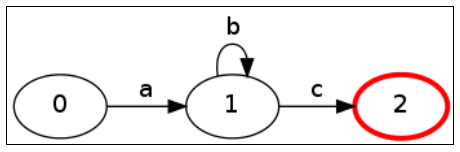

In [105]:
g = Graph()
for i in range(3): g.state()
g.add(0,1,"a")
g.add(1,1,"b")
g.add(1,2,"c")
g.accept(2)
figsize(8,8)
show(g)

Here is a simple matching algorithm.
This algorithm requires that the FSA be deterministic,
i.e., that for a given input sequence, there is only a single
expanded state.

In [124]:
def match(g,s):
    state = 0
    for c in s:
        states = g.expand(state,c)
        #print state,states,c
        if states==[]: return False
        if len(states)>1: raise Exception("non-deterministic")
        state = states[0]
    return g.accepted(state)

In [125]:
print match(g,"abc")
print match(g,"ac")
print match(g,"abbbbc")

False
True
True


In [126]:
print match(g,"aabc")
print match(g,"abbbccc")

True
False


# Wildcards

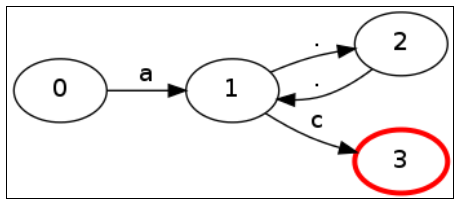

In [127]:
g = Graph()
for i in range(4): g.state()
g.add(0,1,"a")
g.add(1,2,".")
g.add(2,1,".")
g.add(1,3,"c")
g.accept(3)
figsize(8,8)
show(g)

In [130]:
print match(g,"ac")
print match(g,"abc")
print match(g,"abbc")
print match(g,"abbbc")

True
False
True
False


# Building an FST as a Trie

In [85]:
words = sorted("""
    time person year way day thing
    man world life hand part child
    eye woman place work week
    case point government company
    number group problem fact
""".split())

In [86]:
def build_trie(g,state,words,repeat=0):
    #print state,words
    if "" in words: 
        g.accept(state)
        if repeat is not None:
            g.add(state,repeat," ")
    words = [w for w in words if w!=""]
    if words==[]: return
    letters = sorted(list(set([w[0] for w in words])))
    for l in letters:
        substate = g.state()
        g.add(state,substate,l)
        subwords = [w[1:] for w in words if w[0]==l]
        build_trie(g,substate,subwords,repeat=repeat)
        

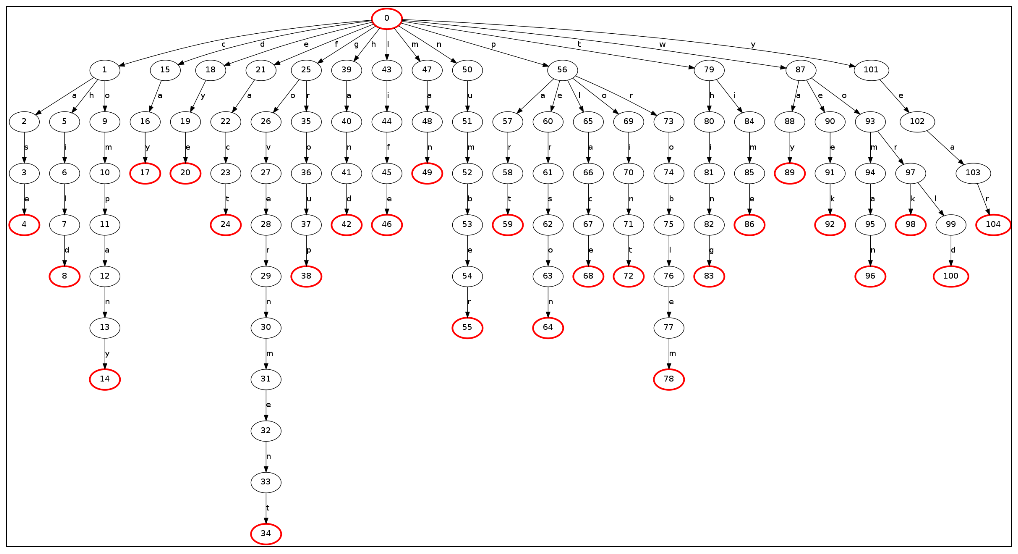

In [87]:
g = Graph()
start = g.state()
g.accept(start)
build_trie(g,start,words,repeat=None)
figsize(18,12)
show(g,rankdir="TB")

In [89]:
print match(g,"hand")
print match(g,"foot")

True
False


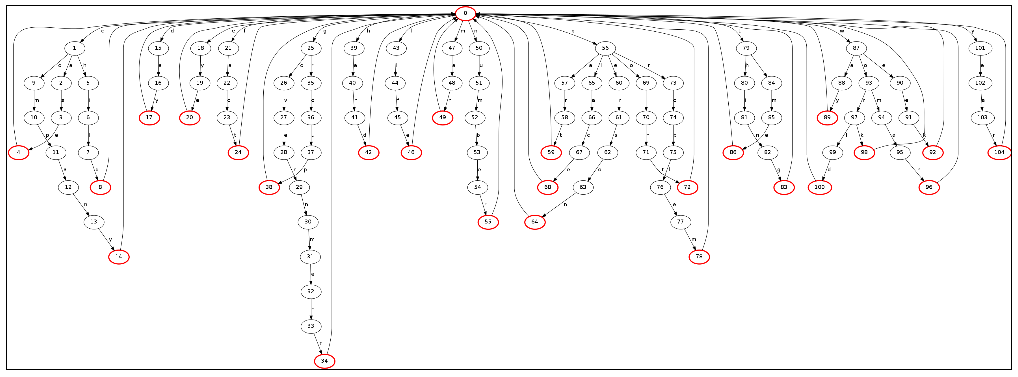

In [90]:
g = Graph()
start = g.state()
g.accept(start)
build_trie(g,start,words,repeat=start)
figsize(18,12)
show(g,rankdir="TB")

In [94]:
print match(g,"hand time person year")
print match(g,"hand time foot year")

True
False


Question: 

- what are equivalent regular expressions?
- how would you translate `^.*\L<word>.*$`?